In [ ]:
pip install scikit-optimize

2Requirement already satisfied: scikit-optimize in /usr/local/lib/python3.11/dist-packages (0.10.2)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif
from skopt import BayesSearchCV


In [ ]:
# Load dataset
data_path = '/content/heart_statlog_cleveland_hungary_final.csv'  # Update with actual filename
df = pd.read_csv(data_path)
df

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1185,45,1,1,110,264,0,0,132,0,1.2,2,1
1186,68,1,4,144,193,1,0,141,0,3.4,2,1
1187,57,1,4,130,131,0,0,115,1,1.2,2,1
1188,57,0,2,130,236,0,2,174,0,0.0,2,1


In [ ]:
# Display dataset info
print("Dataset Shape:", df.shape)
print("Columns:", df.columns)

Dataset Shape: (1190, 12)
Columns: Index(['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol',
       'fasting blood sugar', 'resting ecg', 'max heart rate',
       'exercise angina', 'oldpeak', 'ST slope', 'target'],
      dtype='object')


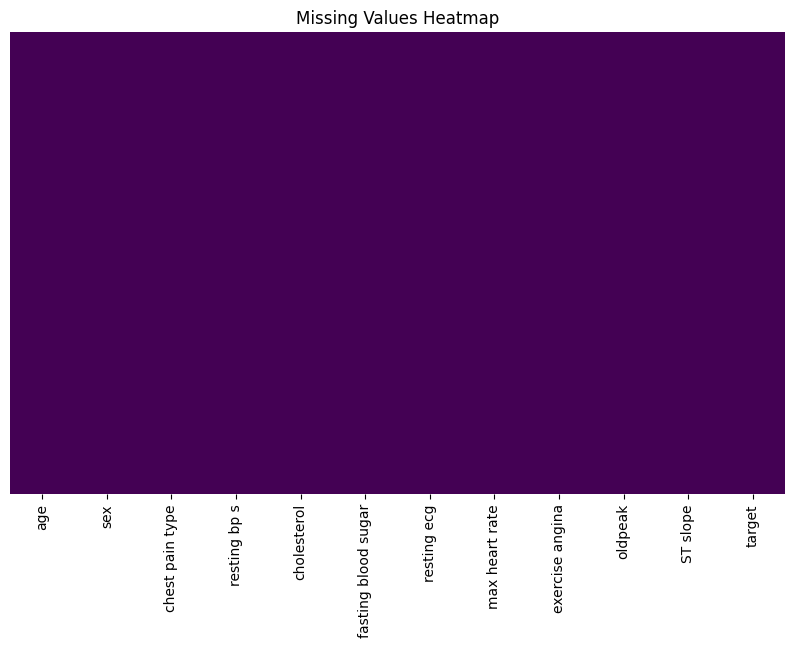

In [ ]:
# Showcase missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

In [ ]:
df.isnull().sum()

,0
age,0
sex,0
chest pain type,0
resting bp s,0
cholesterol,0
fasting blood sugar,0
resting ecg,0
max heart rate,0
exercise angina,0
oldpeak,0


In [ ]:
# Handle missing values
df = df.dropna()

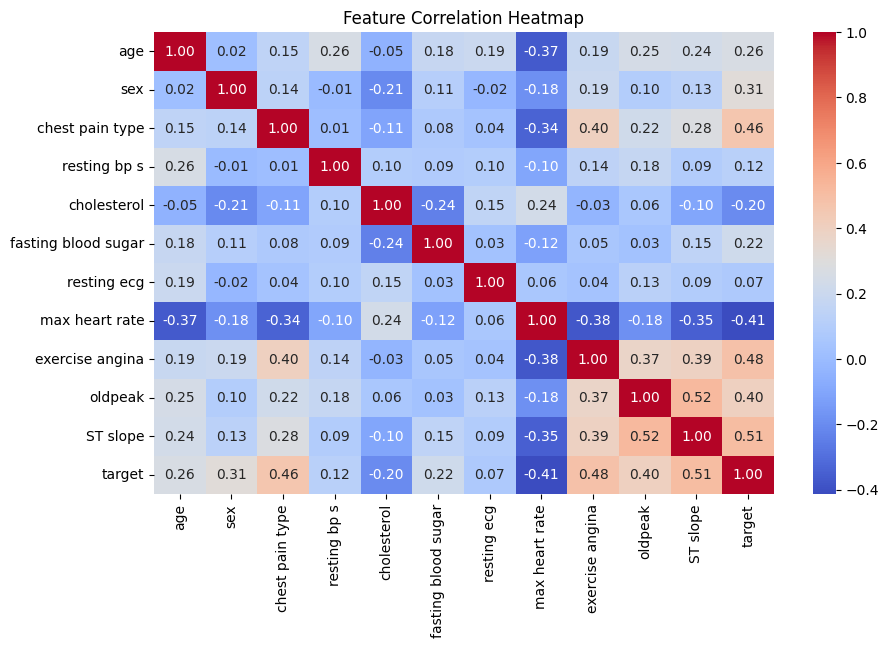

In [ ]:
# Data Visualization
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

<Figure size 1000x600 with 0 Axes>

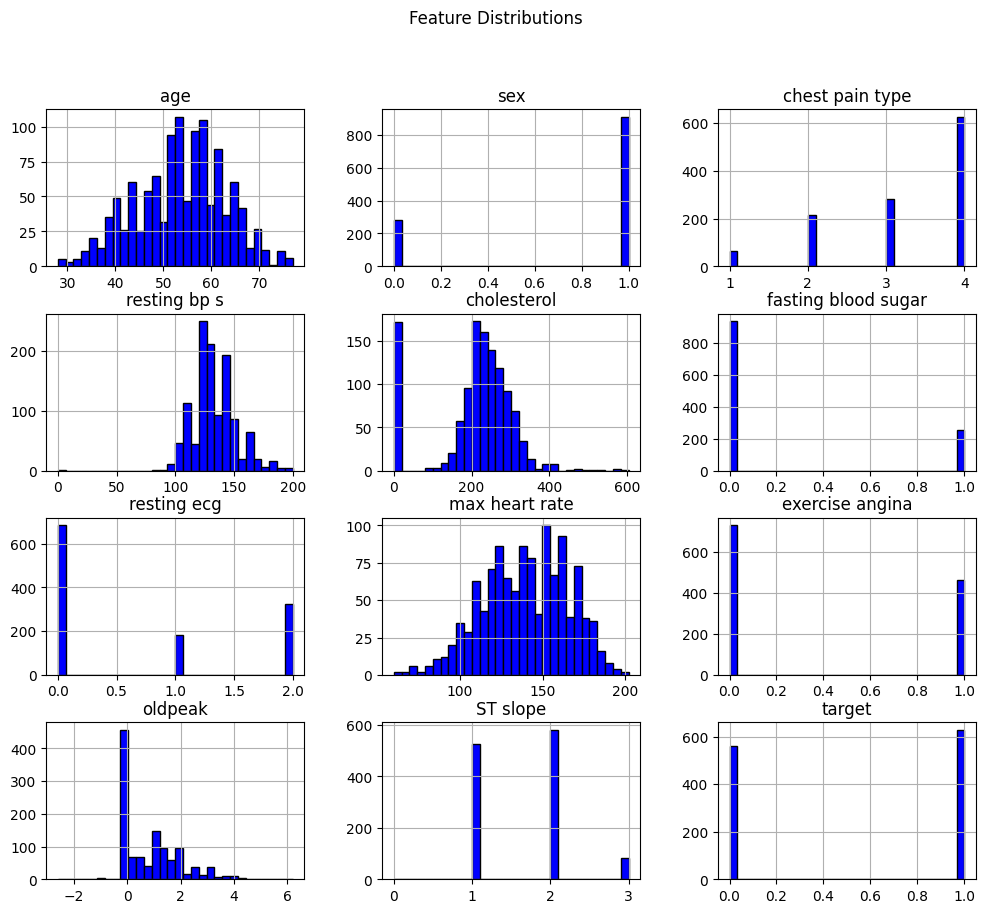

In [ ]:
plt.figure(figsize=(10, 6))
df.hist(bins=30, figsize=(12, 10), color='blue', edgecolor='black')
plt.suptitle("Feature Distributions")
plt.show()

In [ ]:
# Define features and target variable
X = df.drop(columns=['target'])  # Assuming 'target' is the label column
y = df['target']

In [ ]:
# Feature Selection using Fast Conditional Mutual Information Maximization (FCMIM)
selector = SelectKBest(score_func=f_classif, k=10)  # Selecting top 10 features
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected Features (FCMIM):", selected_features)

Selected Features (FCMIM): Index(['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol',
       'fasting blood sugar', 'max heart rate', 'exercise angina', 'oldpeak',
       'ST slope'],
      dtype='object')


In [ ]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# Train SVM Model
svm_model = SVC(kernel='linear', C=1.0, probability=True)  # Linear Kernel for best performance
svm_model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [ ]:
# Predictions
y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test)[:, 1]

In [ ]:
# Model Evaluation
accuracy_fcmim = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [ ]:
# Display Results of compared method fcmim-svm
print("SVM Model Accuracy (FCMIM-SVM):", accuracy_fcmim)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

SVM Model Accuracy (FCMIM-SVM): 0.8487394957983193
Confusion Matrix:
 [[ 88  19]
 [ 17 114]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83       107
           1       0.86      0.87      0.86       131

    accuracy                           0.85       238
   macro avg       0.85      0.85      0.85       238
weighted avg       0.85      0.85      0.85       238



In [ ]:
# Compute ROC Curve
fpr_fcmim, tpr_fcmim, _ = roc_curve(y_test, y_prob)
roc_auc_fcmim = auc(fpr_fcmim, tpr_fcmim)

In [ ]:
#proposed method optimized svm(grid search)
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy', verbose=1)

In [ ]:
# Predictions
y_pred = grid_search.best_estimator_.predict(X_test)
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

In [ ]:
# Compute ROC Curve
fpr_grid, tpr_grid, _ = roc_curve(y_test, y_prob)
roc_auc_grid = auc(fpr_grid, tpr_grid)

In [ ]:
accuracy_opt = accuracy_score(y_test, y_pred)
print("Optimized SVM Model Accuracy:", accuracy_opt)

Optimized SVM Model Accuracy: 0.8949579831932774


In [ ]:
# Model Evaluation
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [ ]:
# Display Results
print("SVM Model Accuracy (grid-SVM):", accuracy_opt)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

SVM Model Accuracy (grid-SVM): 0.8949579831932774
Confusion Matrix:
 [[ 94  13]
 [ 12 119]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88       107
           1       0.90      0.91      0.90       131

    accuracy                           0.89       238
   macro avg       0.89      0.89      0.89       238
weighted avg       0.89      0.89      0.89       238



In [ ]:
# Bayesian Optimization
bayes_param_grid = {
    'C': (0.1, 100, 'log-uniform'),
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}
bayes_search = BayesSearchCV(SVC(probability=True), bayes_param_grid, n_iter=30, cv=5, scoring='accuracy', verbose=1)
bayes_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5, estimator=SVC(probability=True), n_iter=30,
              scoring='accuracy',
              search_spaces={'C': (0.1, 100, 'log-uniform'),
                             'gamma': ['scale', 'auto'],
                             'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
              verbose=1)

In [ ]:
y_pred = bayes_search.best_estimator_.predict(X_test)
y_prob = bayes_search.best_estimator_.predict_proba(X_test)[:, 1]

In [ ]:
# Compute ROC Curve
fpr_bayes, tpr_bayes, _ = roc_curve(y_test, y_prob)
roc_auc_bayes = auc(fpr_bayes, tpr_bayes)

accuracy_bayes = accuracy_score(y_test, y_pred)
print("Bayesian Optimized SVM Accuracy:", accuracy_bayes)

Bayesian Optimized SVM Accuracy: 0.8781512605042017


In [ ]:
# Model Evaluation
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [ ]:
# Display Results
print("SVM Model Accuracy (Bayes-SVM):", accuracy_bayes)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

SVM Model Accuracy (Bayes-SVM): 0.8781512605042017
Confusion Matrix:
 [[ 87  20]
 [  9 122]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.81      0.86       107
           1       0.86      0.93      0.89       131

    accuracy                           0.88       238
   macro avg       0.88      0.87      0.88       238
weighted avg       0.88      0.88      0.88       238



In [ ]:
# Random Search Optimization
random_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}
random_search = RandomizedSearchCV(SVC(probability=True), param_distributions=random_param_grid, n_iter=20, cv=5, scoring='accuracy', verbose=1, random_state=42)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=SVC(probability=True), n_iter=20,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'rbf', 'poly',
                                                   'sigmoid']},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
y_pred = random_search.best_estimator_.predict(X_test)
y_prob = random_search.best_estimator_.predict_proba(X_test)[:, 1]

In [ ]:
# Compute ROC Curve
fpr_random, tpr_random, _ = roc_curve(y_test, y_prob)
roc_auc_random = auc(fpr_random, tpr_random)

accuracy_random = accuracy_score(y_test, y_pred)
print("Random Search Optimized SVM Accuracy:", accuracy_random)

Random Search Optimized SVM Accuracy: 0.8949579831932774


In [ ]:
# Model Evaluation
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [ ]:
# Display Results
print("SVM Model Accuracy (Random-SVM):", accuracy_random)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

SVM Model Accuracy (Random-SVM): 0.8949579831932774
Confusion Matrix:
 [[ 94  13]
 [ 12 119]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88       107
           1       0.90      0.91      0.90       131

    accuracy                           0.89       238
   macro avg       0.89      0.89      0.89       238
weighted avg       0.89      0.89      0.89       238



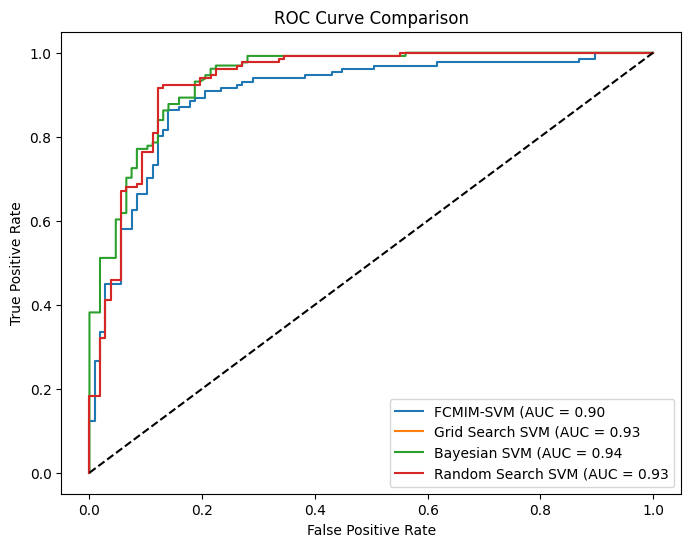

In [ ]:
# ROC Curve Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_fcmim, tpr_fcmim, label=f'FCMIM-SVM (AUC = {roc_auc_fcmim:.2f}')
plt.plot(fpr_grid, tpr_grid, label=f'Grid Search SVM (AUC = {roc_auc_grid:.2f}')
plt.plot(fpr_bayes, tpr_bayes, label=f'Bayesian SVM (AUC = {roc_auc_bayes:.2f}')
plt.plot(fpr_random, tpr_random, label=f'Random Search SVM (AUC = {roc_auc_random:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

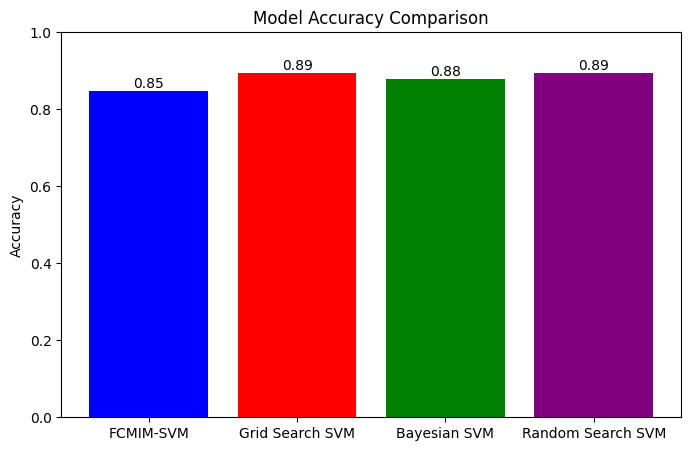

In [ ]:
# Accuracy Comparison Bar Chart
plt.figure(figsize=(8, 5))
bars = plt.bar(['FCMIM-SVM', 'Grid Search SVM', 'Bayesian SVM', 'Random Search SVM'],
        [accuracy_fcmim, accuracy_opt, accuracy_bayes, accuracy_random],
        color=['blue', 'red', 'green', 'purple'])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
for bar, acc in zip(bars, [accuracy_fcmim, accuracy_opt, accuracy_bayes, accuracy_random]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{acc:.2f}', ha='center', va='bottom')
plt.show()

In [ ]:
# Grid Search Optimization with Class Weight Balancing
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced']  # Adding class weight balancing
}

grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Predictions
y_pred = grid_search.best_estimator_.predict(X_test)
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Compute ROC Curve
fpr_grid, tpr_grid, _ = roc_curve(y_test, y_prob)
roc_auc_grid = auc(fpr_grid, tpr_grid)

accuracy_opt = accuracy_score(y_test, y_pred)
print("Optimized SVM Model Accuracy (Balanced):", accuracy_opt)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Optimized SVM Model Accuracy (Balanced): 0.8865546218487395


In [ ]:
import joblib

# Save the best Grid Search model
joblib.dump(grid_search.best_estimator_, "optimized_svm_model.pkl")
print("Optimized SVM model saved successfully!")

# Load the saved model
loaded_model = joblib.load("optimized_svm_model.pkl")
print("Optimized SVM model loaded successfully!")

# Predict risk levels using the test dataset (X_test)
y_pred_test = loaded_model.predict(X_test)

# Add predictions to the test dataset
test_results = pd.DataFrame(X_test, columns=selected_features)
test_results['Actual'] = y_test.values
test_results['Predicted'] = y_pred_test

# Separate low-risk (No Heart Disease) and high-risk (Heart Disease) cases
low_risk_cases = test_results[test_results['Predicted'] == 0]
high_risk_cases = test_results[test_results['Predicted'] == 1]

print(f"Low-Risk Cases: {low_risk_cases.shape[0]}")
print(f"High-Risk Cases: {high_risk_cases.shape[0]}")

# Save predictions
test_results.to_csv("test_results_with_risk.csv", index=False)
print("Test results saved to test_results_with_risk.csv")


Optimized SVM model saved successfully!
Optimized SVM model loaded successfully!
Low-Risk Cases: 102
High-Risk Cases: 136
Test results saved to test_results_with_risk.csv


In [ ]:
import numpy as np
import joblib

# Load the saved optimized model
loaded_model = joblib.load("optimized_svm_model.pkl")

# Function to take user input and make predictions
def predict_heart_disease():
    print("Enter patient details for heart disease prediction:")

    # Collect user input
    age = float(input("Age: "))
    sex = int(input("Sex (0 = Female, 1 = Male): "))
    chest_pain = int(input("Chest Pain Type (1-4): "))
    resting_bp = float(input("Resting Blood Pressure (mm Hg): "))
    cholesterol = float(input("Cholesterol (mg/dl): "))
    fasting_bs = int(input("Fasting Blood Sugar (0 = Normal, 1 = >120 mg/dl): "))
    resting_ecg = int(input("Resting ECG (0-2): "))
    max_hr = float(input("Maximum Heart Rate Achieved: "))
    exercise_angina = int(input("Exercise-Induced Angina (0 = No, 1 = Yes): "))
    oldpeak = float(input("ST Depression (Oldpeak): "))
    st_slope = int(input("ST Slope (1 = Upsloping, 2 = Flat, 3 = Downsloping): "))

    # Create a NumPy array with the input values
    user_data = np.array([[age, sex, chest_pain, resting_bp, cholesterol, fasting_bs, resting_ecg,
                           max_hr, exercise_angina, oldpeak, st_slope]])

    # Apply the same feature selection and scaling used in training
    user_data_selected = selector.transform(user_data)
    user_data_scaled = scaler.transform(user_data_selected)

    # Make prediction
    prediction = loaded_model.predict(user_data_scaled)[0]

    # Display the result
    if prediction == 0:
        print("\n🟢 Low Risk: The patient is unlikely to have heart disease.")
    else:
        print("\n🔴 High Risk: The patient is likely to have heart disease.")

# Run the prediction function
predict_heart_disease()
#Age: 45
#Sex: 1 (Male)
#Chest Pain Type: 2 (Atypical Angina)
#Resting Blood Pressure: 120 mm Hg

#Cholesterol: 180 mg/dl
#Fasting Blood Sugar: 0 (Normal)
#Resting ECG: 0 (Normal)
#Max Heart Rate: 160
#Exercise Angina: 0 (No)
#Oldpeak: 0.5
#ST Slope: 1 (Upsloping)

Enter patient details for heart disease prediction:
Age: 45
Sex (0 = Female, 1 = Male): 1
Chest Pain Type (1-4): 2
Resting Blood Pressure (mm Hg): 120
Cholesterol (mg/dl): 180
Fasting Blood Sugar (0 = Normal, 1 = >120 mg/dl): 1
Resting ECG (0-2): 1
Maximum Heart Rate Achieved: 140
Exercise-Induced Angina (0 = No, 1 = Yes): 1
ST Depression (Oldpeak): 0.5
ST Slope (1 = Upsloping, 2 = Flat, 3 = Downsloping): 2

🔴 High Risk: The patient is likely to have heart disease.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


In [ ]:
# Function to take user input and make predictions
def predict_heart_disease():
    print("Enter patient details for heart disease prediction:")

    # Collect user input
    age = float(input("Age: "))
    sex = int(input("Sex (0 = Female, 1 = Male): "))
    chest_pain = int(input("Chest Pain Type (1-4): "))
    resting_bp = float(input("Resting Blood Pressure (mm Hg): "))
    cholesterol = float(input("Cholesterol (mg/dl): "))
    fasting_bs = int(input("Fasting Blood Sugar (0 = Normal, 1 = >120 mg/dl): "))
    resting_ecg = int(input("Resting ECG (0-2): "))
    max_hr = float(input("Maximum Heart Rate Achieved: "))
    exercise_angina = int(input("Exercise-Induced Angina (0 = No, 1 = Yes): "))
    oldpeak = float(input("ST Depression (Oldpeak): "))
    st_slope = int(input("ST Slope (1 = Upsloping, 2 = Flat, 3 = Downsloping): "))

    # Create a NumPy array with the input values
    user_data = np.array([[age, sex, chest_pain, resting_bp, cholesterol, fasting_bs, resting_ecg,
                           max_hr, exercise_angina, oldpeak, st_slope]])

    # Apply the same feature selection and scaling used in training
    user_data_selected = selector.transform(user_data)
    user_data_scaled = scaler.transform(user_data_selected)

    # Make prediction
    prediction = loaded_model.predict(user_data_scaled)[0]

    # Display the result
    if prediction == 0:
        print("\n🟢 Low Risk: The patient is unlikely to have heart disease.")
    else:
        print("\n🔴 High Risk: The patient is likely to have heart disease.")

# Run the prediction function
predict_heart_disease()

#Age: 62
#Sex: 1 (Male)
#Chest Pain Type: 4 (Asymptomatic)
#Resting Blood Pressure: 150 mm Hg
#Cholesterol: 260 mg/dl
#Fasting Blood Sugar: 1 (>120 mg/dl)
#Resting ECG: 2 (Left Ventricular Hypertrophy)
#Max Heart Rate: 120
#Exercise Angina: 1 (Yes)
#Oldpeak: 2.5
#ST Slope: 2 (Flat)


Enter patient details for heart disease prediction:
